In [58]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
import torch
import torch.nn as nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau

import math
import numpy as np
from pathlib import Path
import requests
from my_tokenizer import CharDataset
from my_gpt import SmolGPT

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")

Using device: cuda


#### Unit testing

In [60]:
!pytest my_tests.py -v

]9;4;3;\============================= test session starts ==============================
platform linux -- Python 3.12.3, pytest-9.0.0, pluggy-1.6.0 -- /home/aenh/git/mini_project_language_model/.venv/bin/python3
cachedir: .pytest_cache
rootdir: /home/aenh/git/mini_project_language_model/src
plugins: anyio-4.11.0
collected 6 items                                                              

my_tests.py::test_tokenizer_roundtrip ]9;4;1;0\PASSED                             [ 16%]
my_tests.py::test_single_attention_head ]9;4;1;16\PASSED                           [ 33%]
my_tests.py::test_multi_attention_head ]9;4;1;33\PASSED                            [ 50%]
my_tests.py::test_ffn ]9;4;1;50\PASSED                                             [ 66%]
my_tests.py::test_transformer_block ]9;4;1;66\PASSED                               [ 83%]
my_tests.py::test_full_model ]9;4;1;83\PASSED                                      [100%]]9;4;0;\

============================== 6 passed 

#### Get Data using DataSet / DataLoader

In [61]:
from torch.utils.data import DataLoader

# Load Shakespeare data
with open('../data/shakespeare.txt', 'r') as f:
    text = f.read()

# Build vocab from entire text ONCE
vocab = sorted(list(set(text)))

# Split into train/val (80/20)
n = int(0.8 * len(text))
train_text, val_text = text[:n], text[n:]

# Create datasets with shared vocab
train_dataset = CharDataset(train_text, block_size=128, vocab=vocab)
val_dataset = CharDataset(val_text, block_size=128, vocab=vocab)

# Create dataloaders 
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

vocab_size = train_dataset.get_vocab_size()


In [62]:
@torch.no_grad()
def estimate_loss(model, train_loader, val_loader, device, eval_batches=50):
    """
    Estimate loss on training and validation sets
    Args:
        model: GPT model
        train_loader: train DataLoader
        val_loader: val DataLoader
        device: cpu or cuda
        eval_batches: nb of batches to average over
    Returns:
        Dictionary with 'train' and 'val' losses
    """
    model.eval()
    out = {}
    
    for split, loader in [('train', train_loader), ('val', val_loader)]:
        losses = []
        for i, (x, y) in enumerate(loader):
            if i >= eval_batches:
                break
            x, y = x.to(device), y.to(device)
            _, loss = model(x, y)
            losses.append(loss.item())
        
        out[split] = sum(losses) / len(losses) if losses else 0
    
    model.train()
    return out

#### Setting hyperparameters

In [ ]:
# The project was tested with 12 layers, 8 attention heads, and 768 embedding dimensions, on a single GPU.

## big
# n_embd=768
# block_size=128
# batch_size = 64
# num_head=8
# num_layers=12
# dropout=0.1
# learning_rate = 1e-4

## small
n_embd = 768
batch_size = 32
block_size = 128
num_head = 8
num_layers = 12
dropout = 0.3
learning_rate = 5e-4 # bigger learning rate to compensate the decay

In [ ]:

def save_and_print_loss(iter, scheduler, loss_history, losses):
    train_loss = losses['train']
    val_loss = losses['val']
    loss_history.append({
            'step': iter,
            'train': losses['train'],
            'val': losses['val']
        })
    #Perplexity, then, is essentially a measure of how many options the model finds plausible on average
    # with lower values indicating fewer options (more confident predictions)
    # and higher values indicating more options (greater uncertainty).
    # https://www.comet.com/site/blog/perplexity-for-llm-evaluation/
    print(f"Step {iter:4d} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Perplexity: {math.exp(val_loss):.4f} | Lr: {scheduler.get_last_lr()}",flush=True)
    return val_loss

def save_model(models_dir, model):
    model_path = models_dir / 'model.pth'
    torch.save(model.state_dict(), model_path)
    print(f"new best, saving model",flush=True)

#### Training loop

In [ ]:
models_dir = Path('../models')
models_dir.mkdir(exist_ok=True)
checkpoint_path = models_dir / 'checkpoint.pt'
    
# Create model and load state
model = SmolGPT(
    vocab_size=vocab_size,
    n_embd=n_embd,
    block_size=block_size,
    num_head=num_head,
    num_layers=num_layers,
    dropout=dropout
).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    
if checkpoint_path.exists():
    print("Loading checkpoint...")
    checkpoint = torch.load(checkpoint_path, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    iter = checkpoint['iter']
    best_val_loss = checkpoint['best_val_loss']
    patience_counter = checkpoint['patience_counter']
    print(f"Resumed from step {iter}, best val loss: {best_val_loss:.4f}")
else:
    print("Starting new training")    
    iter = 0
    best_val_loss = float('inf')
    patience_counter = 0

training_steps = 6000
eval_interval = training_steps // 100

# add early stopping
patience = 6  # stop if val loss doesn't improve for 6 evals

scheduler = ReduceLROnPlateau(
    optimizer, 
    mode='min',
    factor=0.5,
    patience=patience//2, # at the middle of the patience we set
)

loss_history = []

for x, y in train_loader:
    # estimate loss every eval_interval steps
    if iter % eval_interval == 0:
        losses = estimate_loss(model, train_loader, val_loader, device)
        val_loss = save_and_print_loss(iter, scheduler, loss_history, losses)
        scheduler.step(val_loss)
        
        # Early stopping check
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            
            # Save the best model
            save_model(models_dir, model)
        else:
            patience_counter += 1
            print(f"  (no improvement, {patience_counter}/{patience})")
            
            if patience_counter >= patience:
                print(f"Early stopping at step {iter}")
                # Save checkpoint before breaking
                torch.save({
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'iter': iter,
                    'best_val_loss': best_val_loss,
                    'patience_counter': patience_counter,
                }, checkpoint_path)
                break
        
    x, y = x.to(device), y.to(device)

    logits, loss = model(x, y)
    optimizer.zero_grad()
    loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0) # adding gradient clipping
    optimizer.step()

    iter += 1
    if iter >= training_steps:
        # Save checkpoint at the end
        torch.save({
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'iter': iter,
            'best_val_loss': best_val_loss,
            'patience_counter': patience_counter,
        }, checkpoint_path)
        break

print("Training complete!")

Starting new training
Step    0 | Train Loss: 4.2770 | Val Loss: 4.2855 | Perplexity: 72.6377 | Lr: [0.0005]
new best, saving model
Step   60 | Train Loss: 2.4956 | Val Loss: 2.5048 | Perplexity: 12.2415 | Lr: [0.0005]
new best, saving model
Step  120 | Train Loss: 2.3562 | Val Loss: 2.3674 | Perplexity: 10.6699 | Lr: [0.0005]
new best, saving model
Step  180 | Train Loss: 2.0942 | Val Loss: 2.1239 | Perplexity: 8.3639 | Lr: [0.0005]
new best, saving model
Step  240 | Train Loss: 1.9201 | Val Loss: 1.9701 | Perplexity: 7.1711 | Lr: [0.0005]
new best, saving model
Step  300 | Train Loss: 1.8072 | Val Loss: 1.8548 | Perplexity: 6.3903 | Lr: [0.0005]
new best, saving model
Step  360 | Train Loss: 1.7152 | Val Loss: 1.7549 | Perplexity: 5.7826 | Lr: [0.0005]
new best, saving model
Step  420 | Train Loss: 1.6411 | Val Loss: 1.6886 | Perplexity: 5.4121 | Lr: [0.0005]
new best, saving model
Step  480 | Train Loss: 1.5814 | Val Loss: 1.6356 | Perplexity: 5.1326 | Lr: [0.0005]
new best, saving 

#### Plot Loss

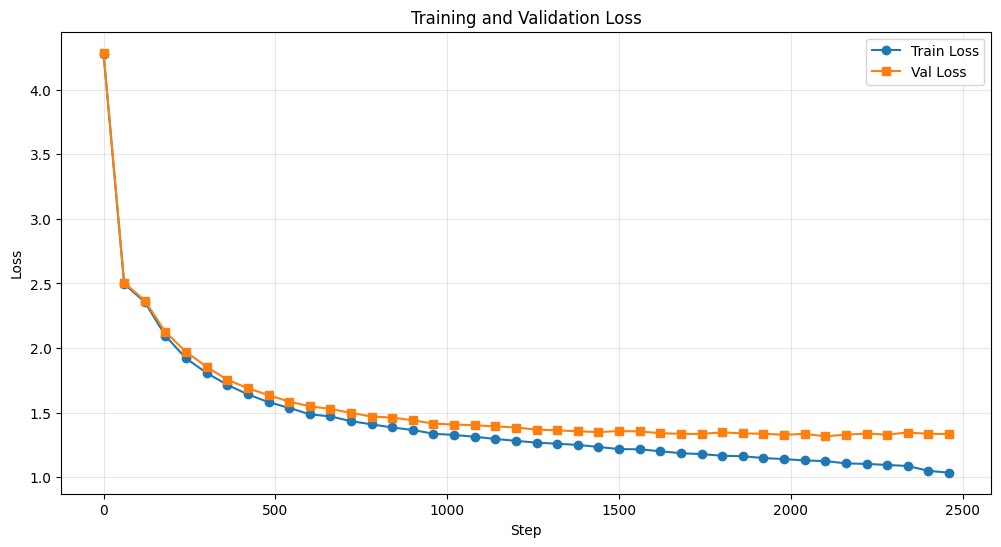

In [69]:
steps = [h['step'] for h in loss_history]
train_losses = [h['train'] for h in loss_history]
val_losses = [h['val'] for h in loss_history]

import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
plt.plot(steps, train_losses, label='Train Loss', marker='o')
plt.plot(steps, val_losses, label='Val Loss', marker='s')
plt.xlabel('Step')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()





#### Generation

In [70]:
def generate_text_completion(dataset, max_new_tokens, context, temperature=1.0):
    print(f'Generation with Max_new_tokens={max_new_tokens} | Context={context} | Temperature={temperature}\n',flush=True)
    tokens = dataset.encode(context)
    #not sure about this, wanting to change the tensor shape
    idx = torch.tensor(tokens).view(1, len(tokens)).to(device)
    y = model.generate(idx, max_new_tokens, temperature)
    completion = dataset.decode(y[0].tolist())
    print(completion, flush=True)
    print("-"*60)

In [73]:
dataset = CharDataset(text, block_size=128)
max_new_tokens = 500

# Load model if not already trained in this session
model_path = Path('../models/model.pth')
if model_path.exists():
    print("Loading trained model")
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.to(device)

model.eval()
with torch.no_grad():
    context = "O God, O God!"
    generate_text_completion(dataset, max_new_tokens, context, temperature=1.0)
    generate_text_completion(dataset, max_new_tokens, context, temperature=0.2)
    generate_text_completion(dataset, max_new_tokens, context, temperature=2.0)
    
    
    context = "Dear cousin, thou art in trouble,"
    generate_text_completion(dataset, max_new_tokens, context, temperature=1.0)
    generate_text_completion(dataset, max_new_tokens, context, temperature=0.2)
    generate_text_completion(dataset, max_new_tokens, context, temperature=2.0)
    
    
    context = "Good day, my lord"
    generate_text_completion(dataset, max_new_tokens, context, temperature=1.0)
    generate_text_completion(dataset, max_new_tokens, context, temperature=0.2)
    generate_text_completion(dataset, max_new_tokens, context, temperature=2.0)

Loading trained model
Generation with Max_new_tokens=500 | Context=O God, O God! | Temperature=1.0

O God, O God!

GLOUCESTER:
Now, more he shall in my liege,
Great king, and that say I thrift toad
Which lives do alike. I am a corrector of foe.

JULIET:
It is behind; why never shall we were act o' the scope,
Which many brother do this land? I am a king
To make that fearful duty friends and masterless
That war from Lancaster's blance
Is Appellant,
The prince, let me be rest your mistress,
For I'll time to what we come again.

BISHOP OF ELY:
To-night;
The Warwick battless are my tongue and my country;
Richar
------------------------------------------------------------
Generation with Max_new_tokens=500 | Context=O God, O God! | Temperature=0.2

O God, O God!

CORIOLANUS:
I had been to be the stronger of the story
That they shall be the streets of their state,
And then they shall be contented to the world.

GLOUCESTER:
Then we shall be still the state of the state,
And then they shall be 